<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/EX_BS2_project9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 환경설정

In [ ]:
!pip uninstall tensorflow
!pip uninstall kerasy

In [ ]:
!pip install tensorflow==2.6.0
!pip install keras==2.6.0

In [ ]:
!pip3 install pixellib

In [2]:
from importlib_metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.6.0
0.7.1


## 1. 기본 인물 사진



In [4]:
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(625, 500, 3)


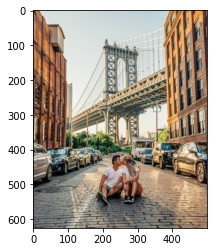

In [8]:
img_path = "/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/NYC's Top 10 Most Instagram Worthy Spots.png"
img_person = cv2.imread("/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/NYC's Top 10 Most Instagram Worthy Spots.png") 

print(img_person.shape)
plt.imshow(cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# 저장할 파일 이름을 결정합니다
model_file = ('/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fdc08030110>)

In [7]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [9]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [10]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

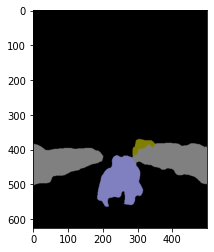

In [11]:
plt.imshow(output)
plt.show()

In [12]:
segvalues

{'class_ids': array([ 0,  6,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [13]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bus
car
person


In [14]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
colormap[15]

array([192, 128, 128])

BGR 컬러이기 때문에 RGB로 바꿔줌

In [16]:
seg_color = (128,128,192)

(625, 500)


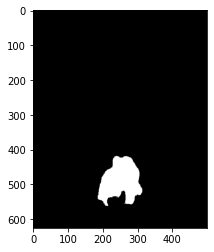

In [17]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원래 이미지와 겹쳐서 segmentation이 잘 되었는지 확인

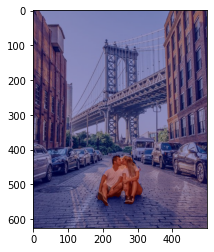

In [19]:
img_show = img_person.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

배경 흐리게 하기

blur함수 사용

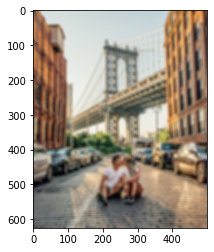

In [23]:
img_person_blur = cv2.blur(img_person, (10,10))  
plt.imshow(cv2.cvtColor(img_person_blur, cv2.COLOR_BGR2RGB))
plt.show()

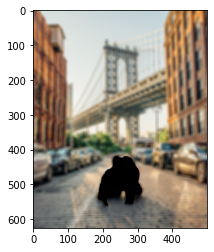

In [25]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_person_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

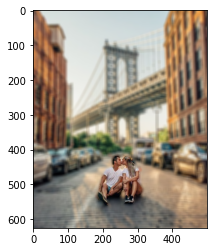

In [26]:
img_concat = np.where(img_mask_color==255, img_person, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 고양이 사진

- 이미지 불러오기

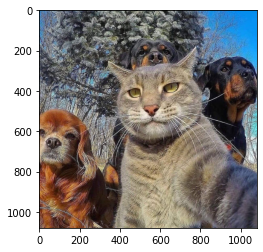

In [28]:
img_path_cat = "/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/Good Morning 😼.png"
img_cat = cv2.imread(img_path_cat)
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
segvalues, output = model.segmentAsPascalvoc(img_path_cat)

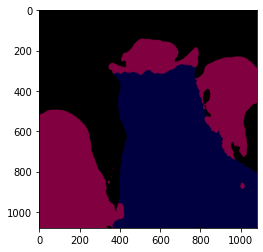

In [30]:
plt.imshow(output)
plt.show()

In [31]:
segvalues

{'class_ids': array([ 0,  8, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

- 12번이 개, 8번이 고양이

In [34]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
dog


In [35]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [38]:
colormap[8]

array([64,  0,  0])

In [39]:
seg_color = (0,0,64)

(1080, 1080)


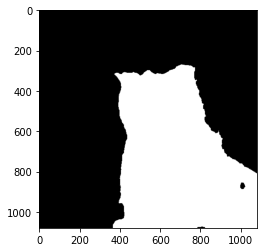

In [40]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

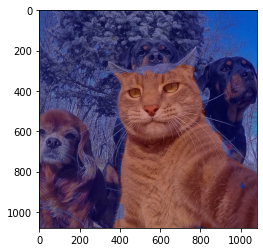

In [41]:
img_show = img_cat.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

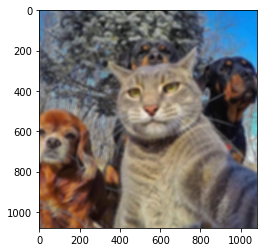

In [46]:
img_cat_blur = cv2.blur(img_cat, (15,15))  
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

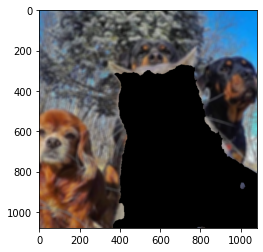

In [47]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

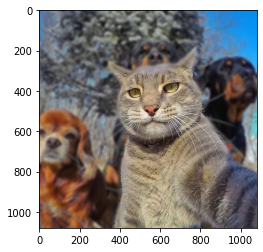

True

In [49]:
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 블러 처리한 이미지 저장
cv2.imwrite('/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/고양이.png',img_concat)

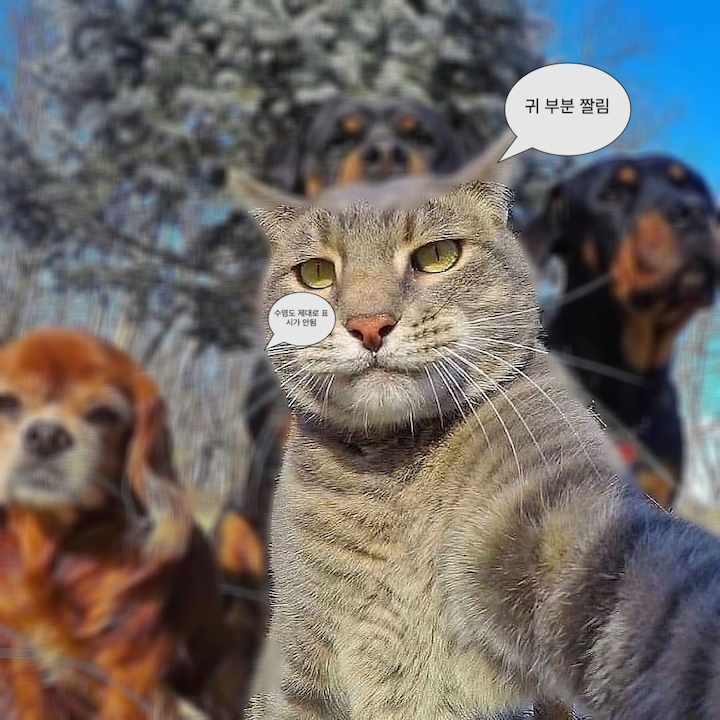

## 3. 크로마키

- 이미지 불러오기

(625, 500, 3)


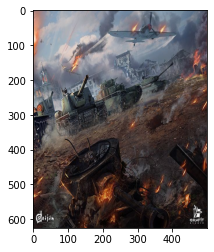

In [53]:
# 배경으로 쓸 이미지
img_war_path = '/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/Warthunder.png'
img_war = cv2.imread(img_war_path)
print(img_war.shape)
plt.imshow(cv2.cvtColor(img_war, cv2.COLOR_BGR2RGB))
plt.show()

(625, 500, 3)


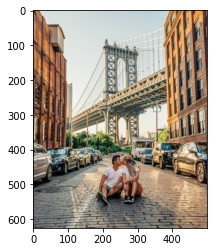

In [52]:
# 붙여넣을 이미지
img_person_path = "/content/drive/MyDrive/AIFFEL/EX/9. 인물사진 만들기/NYC's Top 10 Most Instagram Worthy Spots.png"
img_person = cv2.imread(img_person_path)
print(img_person.shape)
plt.imshow(cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB))
plt.show()

In [54]:
segvalues, output = model.segmentAsPascalvoc(img_person_path)

In [55]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [56]:
colormap[15]

array([192, 128, 128])

In [57]:
seg_color = (128, 128, 192)

(625, 500)


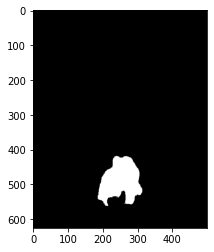

In [66]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [67]:
img_show = img_war.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

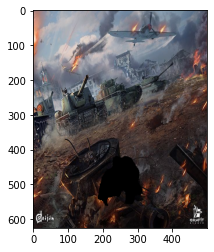

In [69]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_war, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

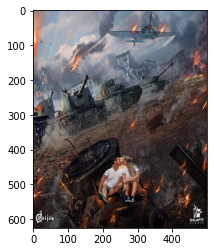

In [72]:
img_concat = np.where(img_mask_color==255, img_person, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 회고 & 문제해결 방법 

- 문제해결 방법 생각

먼저 문제가 생기는 이유를 추측해보면 고양이 이미지에서 segmentation을 할 때 이미지값을 기반으로 구분해서 문제가 생긴 것 같다. 아마도 뒤에있는 나뭇잎 색이랑 고양이 털 색깔이랑 비슷해서 그런 문제가 생긴 것 같은데 요즘 많이들 연구중인 ToF 기술을 이용해 사진에 각 물체들의 거리에 대한 정보도 넣고, 그 정보를 이용하면 segmentation이 좀 더 편리해질 것 같다. 

지금까지 카메라로 사진을 찍으면 3채널 데이터(R,G,B)로 저장을 했지만 이제 ToF를 이용해 사진을 찍으면 거기에 거리에 대한 정보를 함께 담아서 저장하는거다. 하지만 거리는 연속적인 값이기 때문에 어느정도 구간화를 하여 데이터로 기록을 해주면 될 것 같다. 

그렇게 된다면 이미지에서 픽셀값이 서로 비슷하거나 같다고 하더라고 둘의 거리가 다르면 다른 물체로 인식해 segmentation의 성능이 더 올라갈것같다.

- 회고

이번 익스는 내용도 내용이지만 처음 코랩 환경설정이 제일 난이도가 높았다... 패키지 버전에 따른 차이는 생각도 안해봤는데.. 처음에는 진짜 너무 열받았는데 역시 구글은 신이다. ㅋ_ㅋ 일단 내가 겪은 문제는 과거에 누군가가 무조건 한 번 이상은 겪은 문제이기 때문에 해결 방법이 없는 경우가 잘 없다. 뭐 영어로 돼있는게 문제라면 문제지만 그거야 천천히 읽어보면 되니까 ㅎㅎ 이래서 다들 정보의 바다~ 정보의 바다~ 하는가보다. 

여하튼, 익스를 진행 하면서 처음엔 단순하게 객체를 인식하고, 그걸 잘라내고 어디 붙여넣고 하는 과정이 신기하고 재밌었다. 근데 이제 마지막에 segmentation의 문제에 대한 해결방안을 찾으려고 3D이미지 센서에 대해서 보면서 언제까지 2D이미지랑 놀진 못하겠다는 생각이 들었다. 어서 빨리 나도 3D이미지 인식 분야에 조금이나마 이바지할 수 있도록 노력해야겠따.